<a href="https://colab.research.google.com/github/sumeet0701/time_series_analysis/blob/main/RELIEANCE%20Stock%20Price%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore' )
import datetime
import math

import io
sns.set_style('darkgrid')
import plotly.express as px
import plotly.graph_objects as go

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


In [3]:

import yfinance as yf

# Initializing the Ticker object
rel_ticker ='RELIANCE.NS'

# Extracting the history
df = yf.download(tickers= rel_ticker,start='2015-01-01')

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,405.186554,407.792389,403.975037,405.917999,382.812164,1481821
2015-01-02,406.009430,409.643921,404.272217,404.843658,381.798981,3665683
2015-01-05,404.592224,407.289520,399.609100,400.409149,377.616882,5051970
2015-01-06,397.734741,399.106232,380.362396,382.236786,360.478973,9313990
2015-01-07,382.693970,392.614471,382.648254,390.557220,368.325775,10360156


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-11,2978.000000,2978.000000,2927.000000,2933.199951,2933.199951,5638565
2024-03-12,2933.199951,2976.000000,2930.050049,2950.850098,2950.850098,4716339
2024-03-13,2959.550049,2966.199951,2855.550049,2864.350098,2864.350098,6761067
2024-03-14,2879.399902,2897.050049,2851.000000,2862.949951,2862.949951,9285551
2024-03-15,2851.899902,2866.449951,2825.800049,2836.449951,2836.449951,9610095


In [6]:
df.shape

(2273, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2273 entries, 2015-01-01 to 2024-03-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2273 non-null   float64
 1   High       2273 non-null   float64
 2   Low        2273 non-null   float64
 3   Close      2273 non-null   float64
 4   Adj Close  2273 non-null   float64
 5   Volume     2273 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 124.3 KB


In [8]:
df.describe().astype(int)

,Open,High,Low,Close,Adj Close,Volume
count,2273,2273,2273,2273,2273,2273
mean,1372,1386,1356,1371,1354,9419397
std,769,775,761,768,772,6945604
min,373,373,364,370,349,852828
25%,609,614,603,608,587,5459276
50%,1185,1204,1175,1188,1168,7448685
75%,2172,2196,2149,2174,2164,10729875
max,3011,3024,2974,3014,3014,71341683


In [9]:
df_new = df.reset_index()

In [10]:
df_new.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,405.186554,407.792389,403.975037,405.917999,382.812164,1481821
1,2015-01-02,406.009430,409.643921,404.272217,404.843658,381.798981,3665683
2,2015-01-05,404.592224,407.289520,399.609100,400.409149,377.616882,5051970
3,2015-01-06,397.734741,399.106232,380.362396,382.236786,360.478973,9313990
4,2015-01-07,382.693970,392.614471,382.648254,390.557220,368.325775,10360156


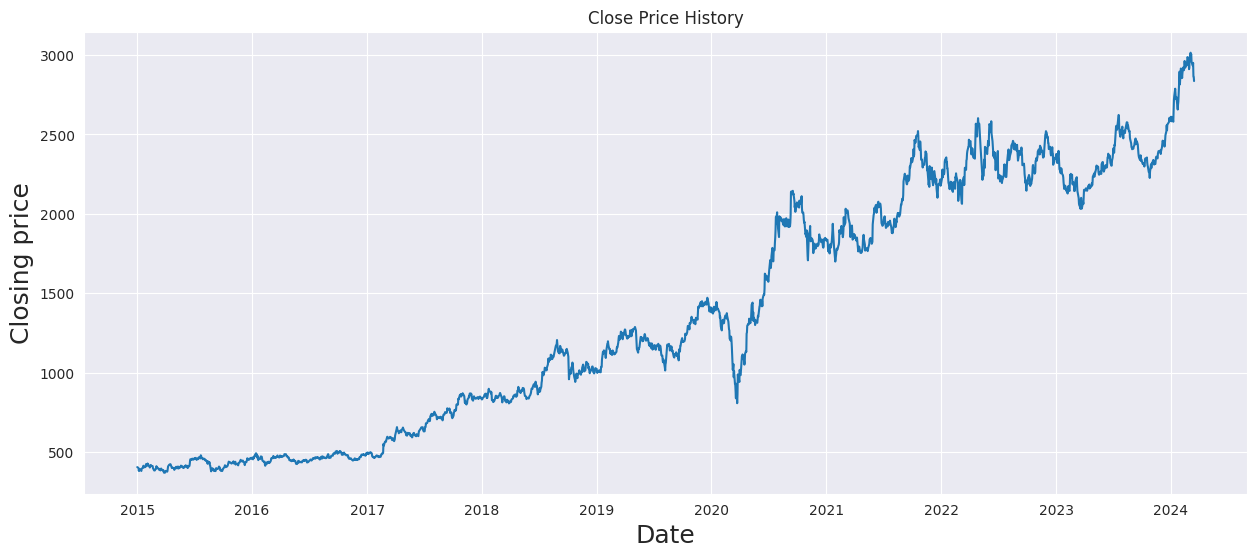

In [11]:
# ploting close price
import datetime
plt.figure(figsize=(15,6))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.xlabel("Date",fontsize = 18)
plt.ylabel("Closing price",fontsize = 18)
plt.show()

In [12]:
fig = px.line(x=df.index, y=df['Close'])

# Updating layout
fig.update_layout(
    title='Close Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    xaxis_rangeslider_visible=True
)

# Showing figure
fig.show()

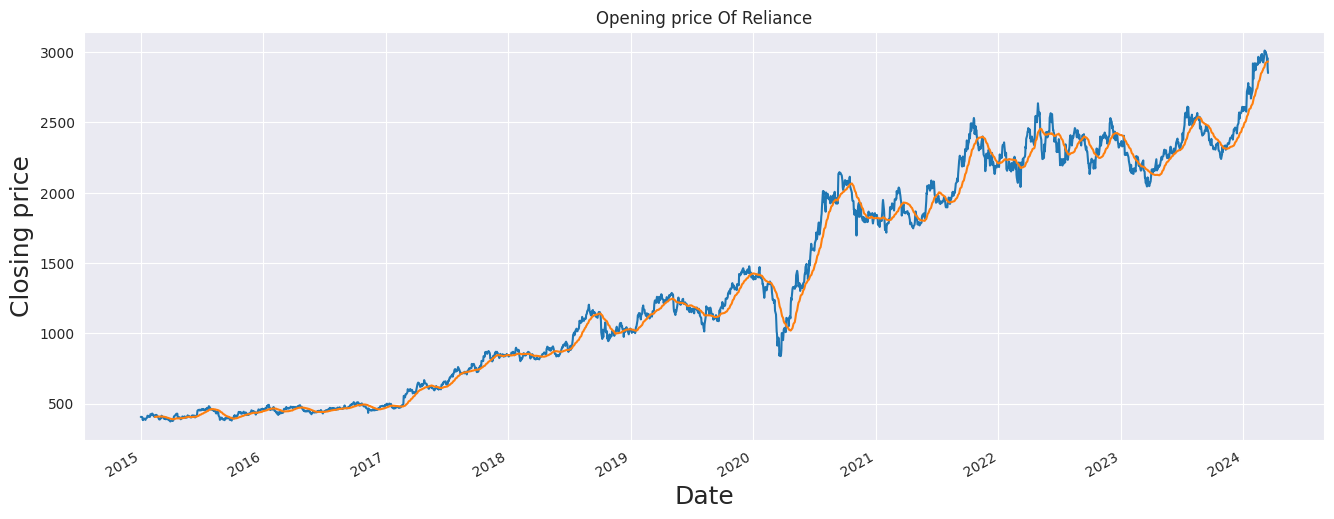

In [13]:
# 30 days moving average
df['Open'].plot(figsize=(16,6))
df.rolling(window=30).mean()['Close'].plot(label="30-day Moving Average")
plt.title("Opening price Of Reliance")
plt.xlabel("Date",fontsize = 18)
plt.ylabel("Closing price",fontsize = 18)
plt.show()

### Creating some Technical Indicators

In [14]:

def get_technical_indicators(dataset): #function to generate feature technical indicators


    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()

    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)


    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1



    return dataset

In [15]:
update_df = get_technical_indicators(df)

In [16]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Amazon - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

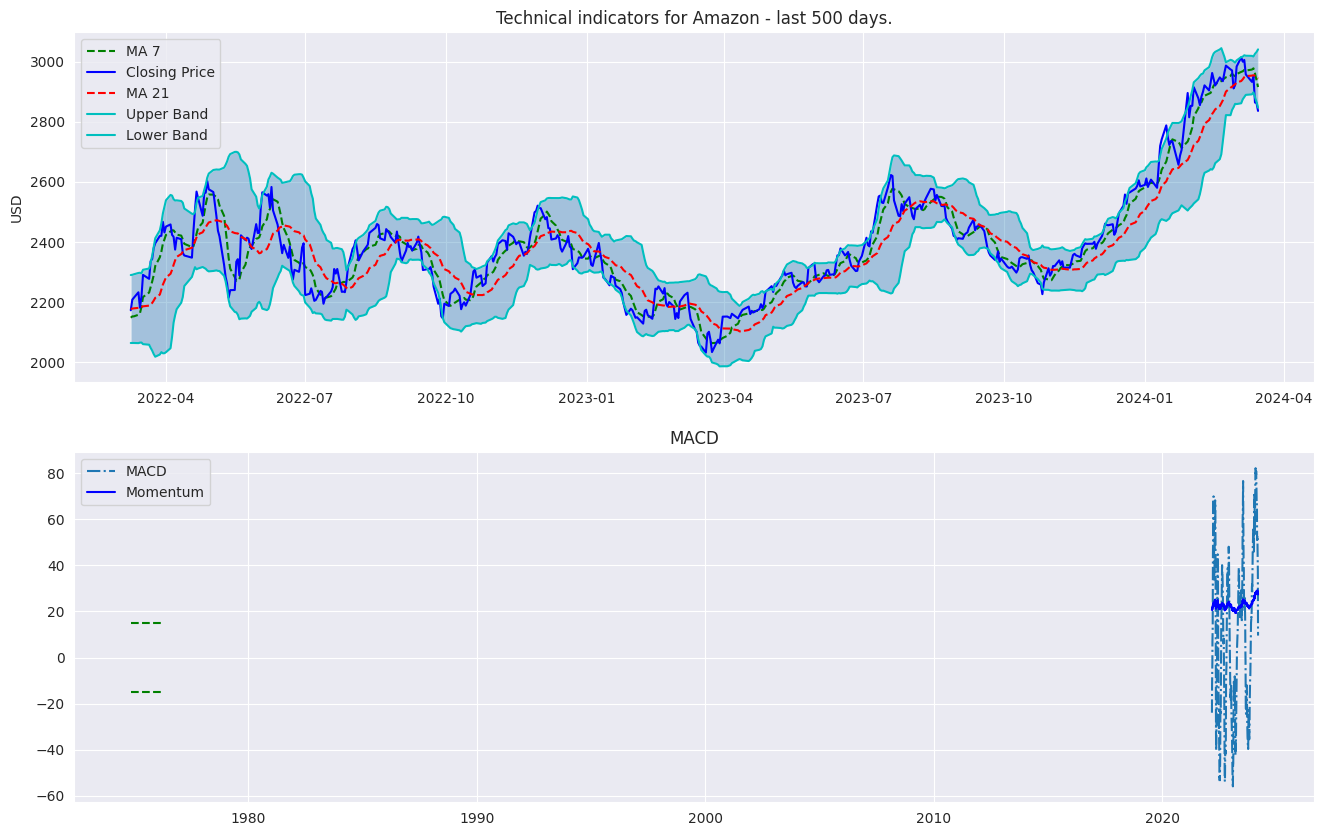

In [17]:
plot_technical_indicators(update_df, 500)

In [18]:
monthvise= df_new.groupby(df_new['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,1365.300196,1363.627628
February,1396.238190,1396.255925
March,1294.984672,1294.601992
April,1239.385712,1240.092319
May,1258.370674,1255.948297
June,1320.399131,1320.558159
July,1354.127568,1354.305522
August,1410.334070,1409.410638
September,1455.309823,1454.575669


In [19]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()


In [20]:
df_new.groupby(df_new['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = df_new.groupby(df_new['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = df_new.groupby(df_new['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Relieance high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Relieance low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

Text(0.5, 1.0, 'Closing Price')

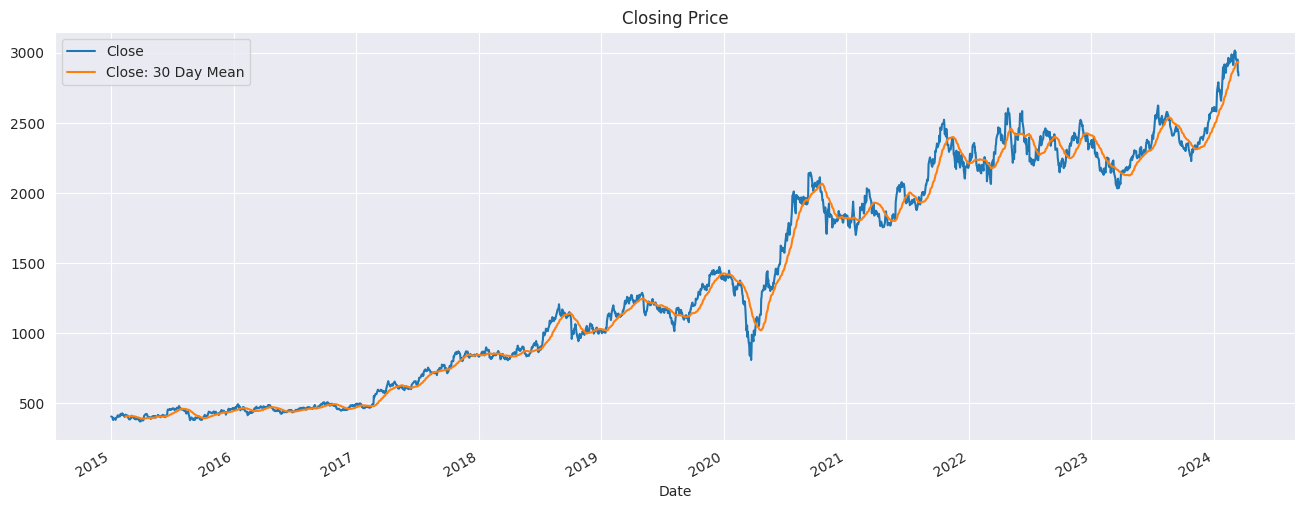

In [21]:
df['Close: 30 Day Mean']=df['Close'].rolling(window=30).mean()
df[['Close','Close: 30 Day Mean']].plot(figsize=(16,6))
plt.title("Closing Price")

In [22]:
from itertools import cycle
names = cycle(['Open','Stock Close Price','Stock High Price','Stock Low Price'])
fig = px.line(df_new, x=df_new.Date, y=[df_new['Open'], df_new['Close'],
                                          df_new['High'], df_new['Low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [23]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objs import Line

fig = make_subplots(rows=4, cols=1,subplot_titles=('Open','High','Low','Close'))

fig.add_trace(
    Line(x=df.index, y=df.Open),
    row=1, col=1
)

fig.add_trace(
    Line(x=df.index, y=df.High),
    row=2, col=1
)

fig.add_trace(
    Line(x=df.index, y=df.Low),
    row=3, col=1
)

fig.add_trace(
    go.Line(x=df.index, y=df.Close),
    row=4, col=1
)

fig.update_layout(height=1400, width=1000, title_text="OHLC Line Plots")

fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [24]:
# **candle Plot**
# Creating the figure object
import plotly.graph_objects as go
fig = go.Figure()

# Creating the Candlestick plot
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
))

# Updating layout
fig.update_layout(
    title='Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    xaxis_rangeslider_visible=True
)
fig.show()

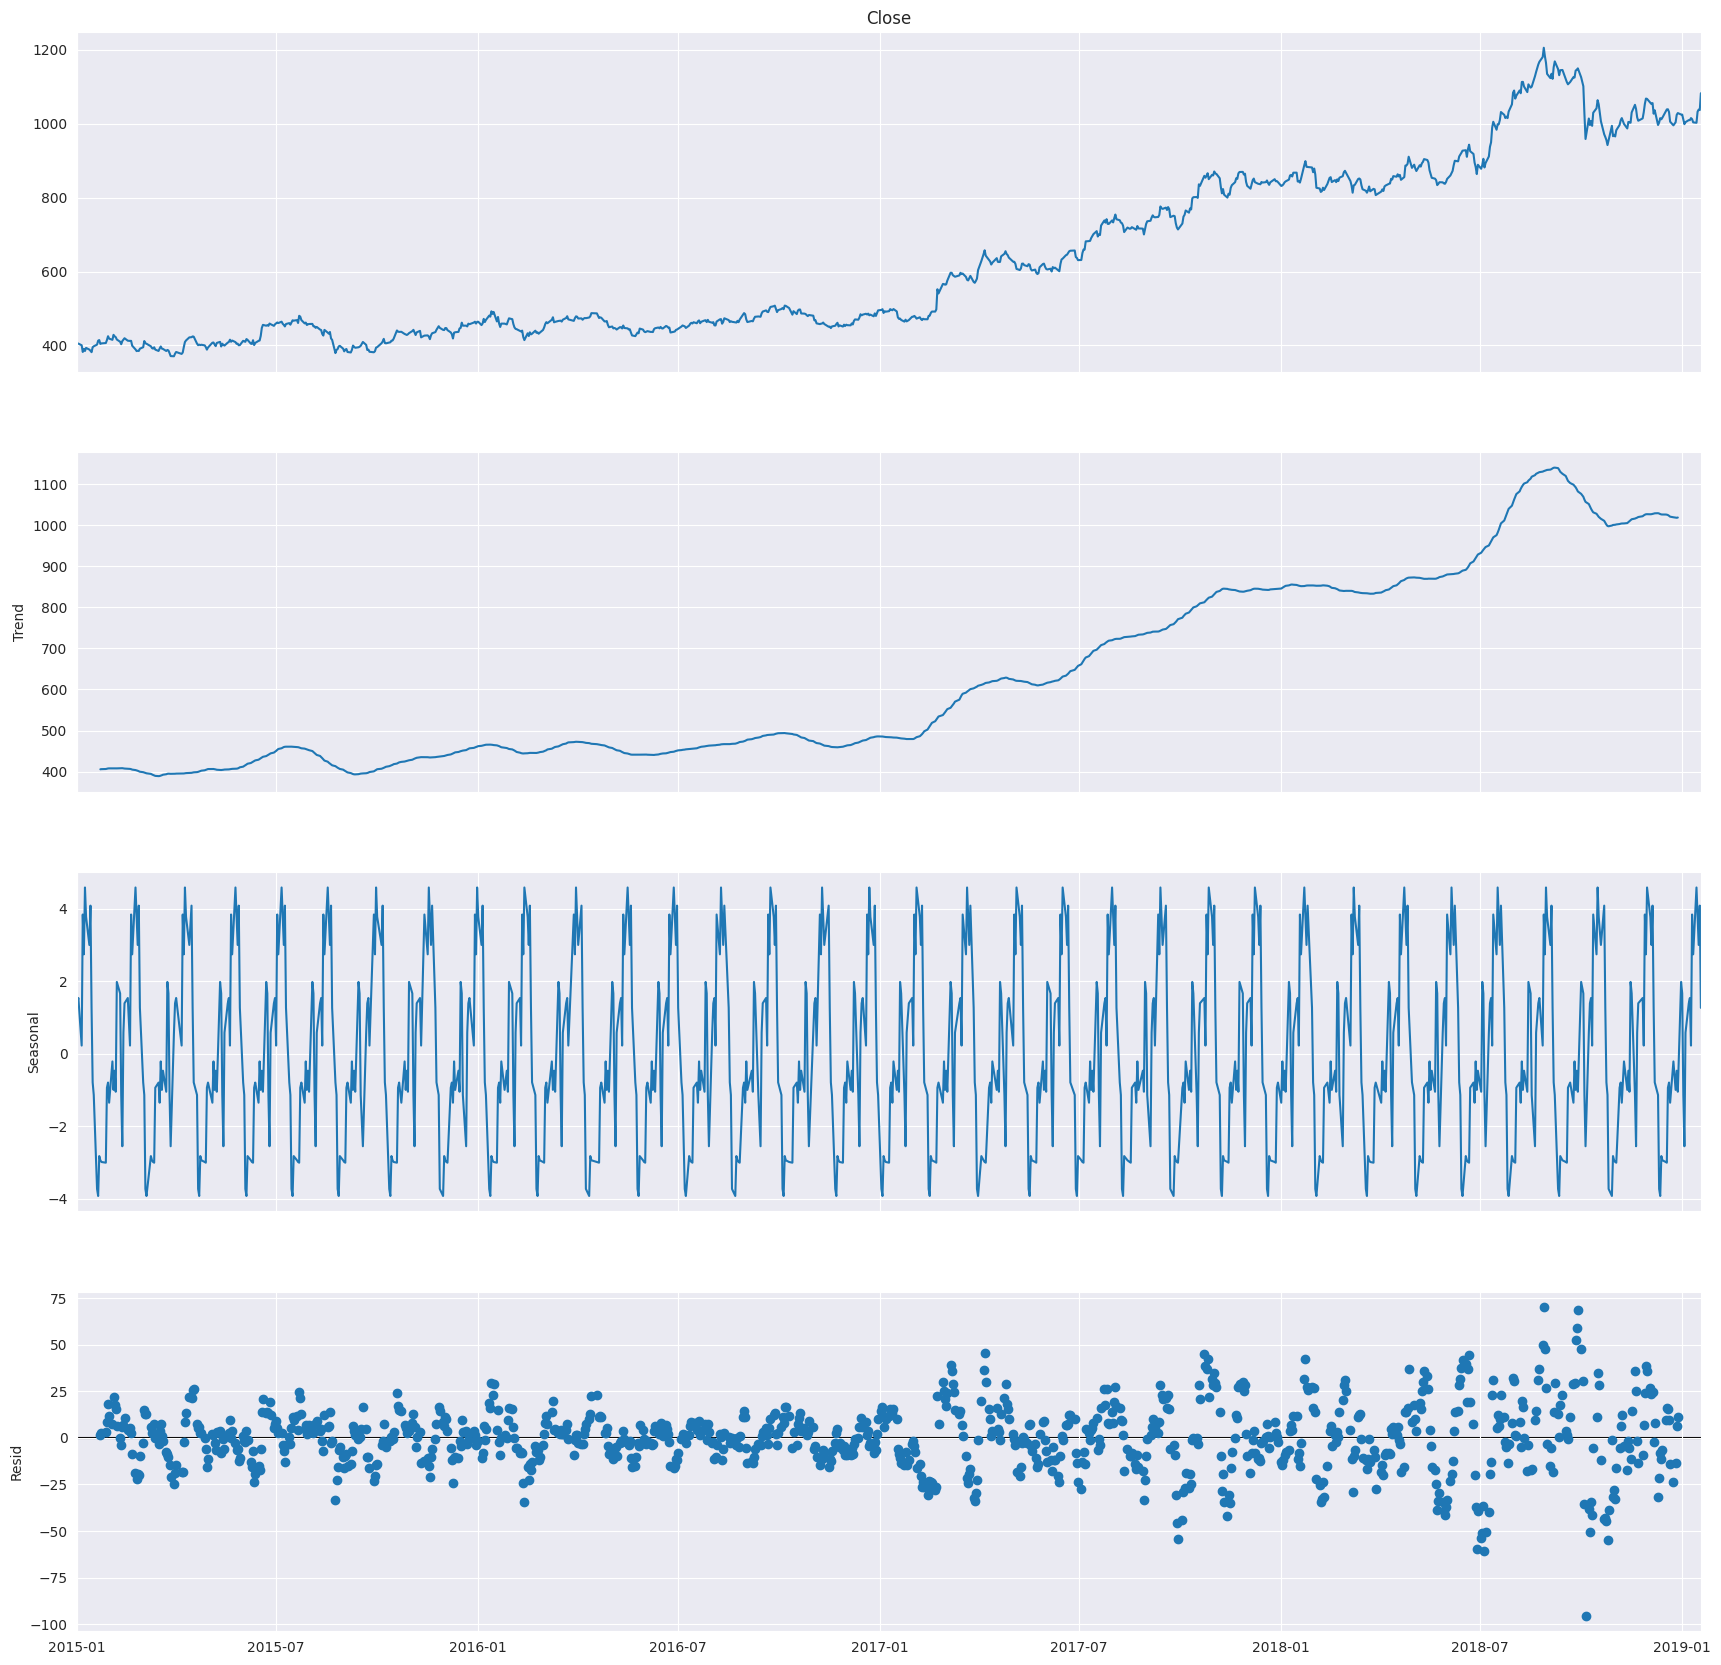

In [25]:
#only first 5000 values are taken because it was looking very crowded
result = seasonal_decompose(df["Close"].head(1000), model='additive', period = 30)
fig = go.Figure()
fig = result.plot()
fig.set_size_inches(20, 19)

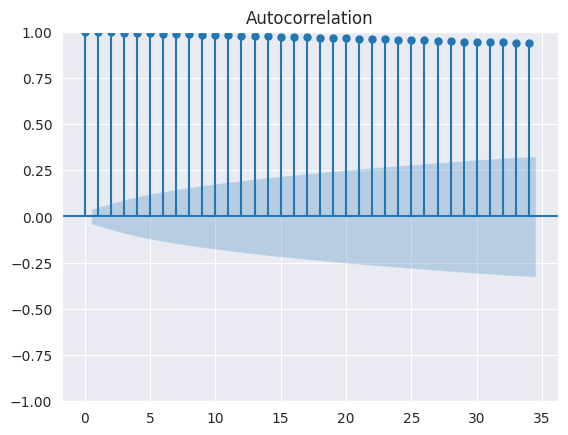

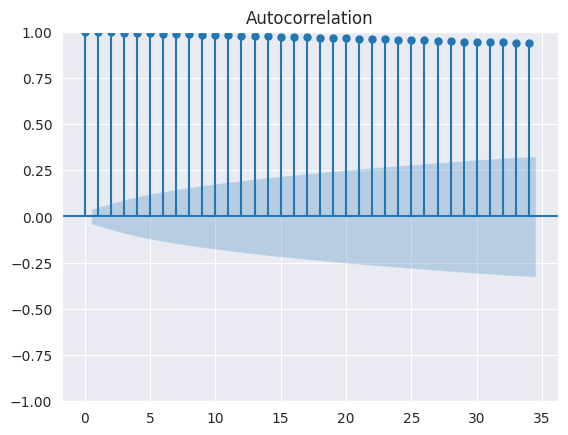

In [26]:
plot_acf(df['Adj Close'], alpha = 0.05)

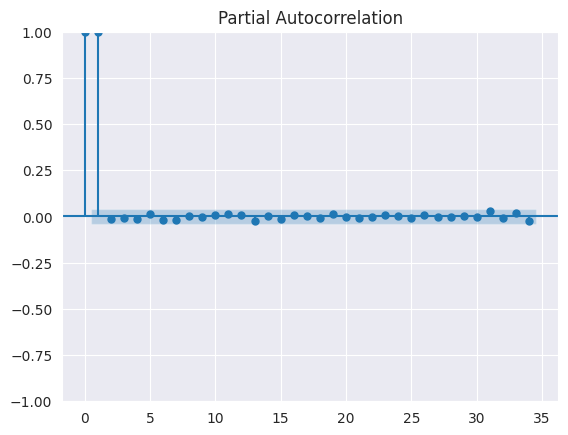

In [27]:
plot_pacf(df['Adj Close'], alpha = 0.05);

In [28]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [29]:
adf_test(df['Close'])

ADF Statistics: -0.14297053442608423
p- value: 0.9449867176763492
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [30]:
df['Close_diff']=df['Close']-df['Close'].shift(1)

In [31]:
adf_test(df['Close_diff'].dropna())

ADF Statistics: -28.429511494946432
p- value: 0.0
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


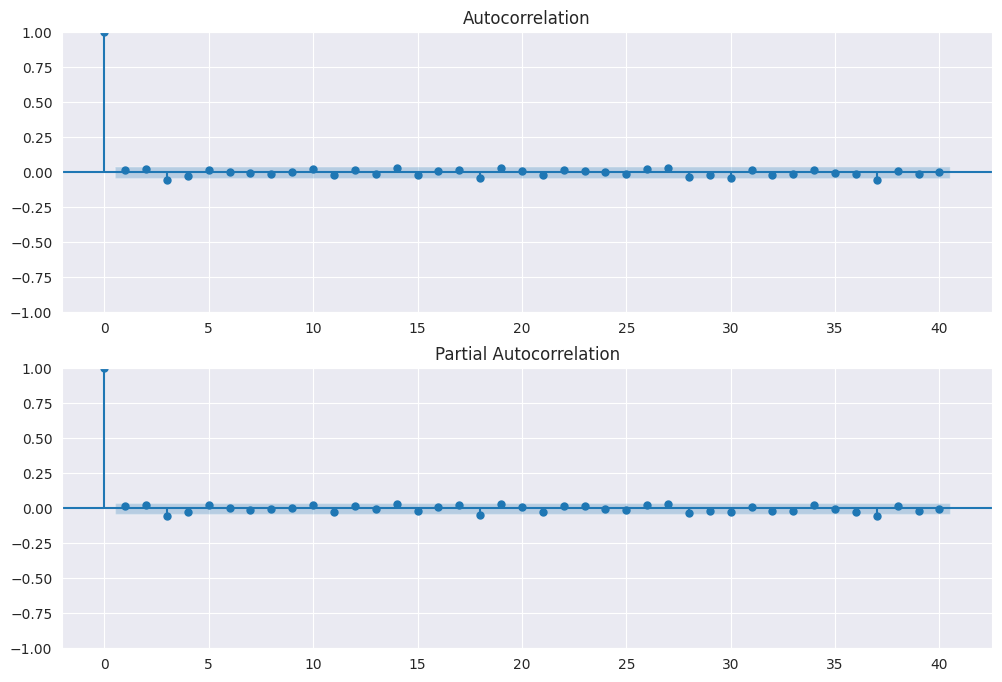

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Close_diff'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Close_diff'].dropna(),lags=40,ax=ax2)

In [33]:
# spliting a dataset in to train and test
# Calculate the size of the training and test sets
df = df[['Close']]
train_size = int(len(df) * 0.8)

# Split the df into training and test sets
train = df[:train_size]
test = df[train_size:]

In [34]:
train

,Close
Date,
2015-01-01,405.917999
2015-01-02,404.843658
2015-01-05,400.409149
2015-01-06,382.236786
2015-01-07,390.557220
...,...
2022-05-10,2284.101074
2022-05-11,2260.703125
2022-05-12,2214.645508


In [35]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=30).mean()
    MSTD = timeseries.rolling(window=30).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [36]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

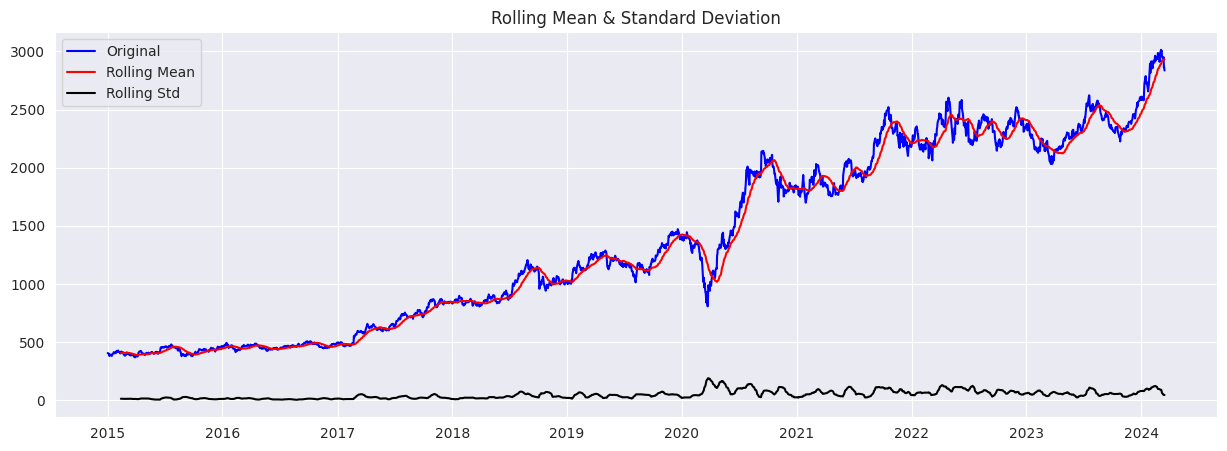

Results of Dickey-Fuller Test:
Test Statistic                   -0.142971
p-value                           0.944987
#Lags Used                        3.000000
Number of Observations Used    2269.000000
Critical Value (1%)              -3.433235
Critical Value (5%)              -2.862815
Critical Value (10%)             -2.567449
dtype: float64


In [37]:
test_stationarity(df['Close'])

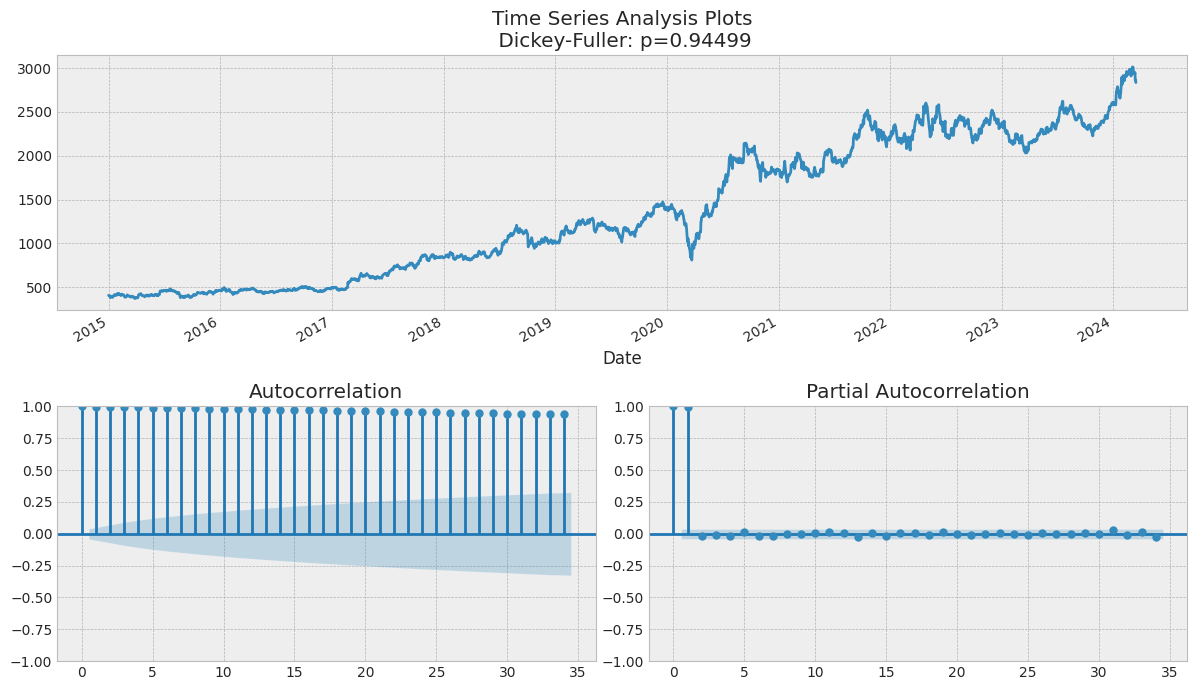

In [38]:
tsplot(df['Close'])

In [39]:
model = ARIMA(df['Close'],order = (1,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2273
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -10595.380
Date:                Fri, 15 Mar 2024   AIC                          21198.759
Time:                        19:07:20   BIC                          21221.673
Sample:                             0   HQIC                         21207.118
                               - 2273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4201      0.288     -1.458      0.145      -0.985       0.145
ma.L1          0.4406      0.287      1.533      0.125      -0.123       1.004
ma.L2          0.0465      0.014      3.288      0.0

In [40]:
size = int(len(df) - 30)
train, test = df['Close'][0:size], df['Close'][size:len(df)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = ARIMA(history, order=(1,1,2))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))


	 ARIMA MODEL : In- Sample Forecasting 

predicted = 2856.965736, expected = 2915.399902
predicted = 2915.173703, expected = 2878.050049
predicted = 2880.481567, expected = 2855.600098
predicted = 2852.218122, expected = 2884.300049
predicted = 2885.136624, expected = 2900.250000
predicted = 2901.743691, expected = 2921.500000
predicted = 2922.005458, expected = 2904.699951
predicted = 2905.098869, expected = 2930.199951
predicted = 2929.682264, expected = 2962.750000
predicted = 2964.889651, expected = 2941.199951
predicted = 2941.421488, expected = 2921.149902
predicted = 2919.499685, expected = 2948.000000
predicted = 2948.316392, expected = 2942.050049
predicted = 2943.141606, expected = 2935.399902
predicted = 2934.476284, expected = 2963.500000
predicted = 2964.112213, expected = 2987.250000
predicted = 2988.820700, expected = 2974.649902
predicted = 2974.769403, expected = 2971.300049
predicted = 2970.515221, expected = 2911.250000
predicted = 2910.219858, expected = 2921.600098

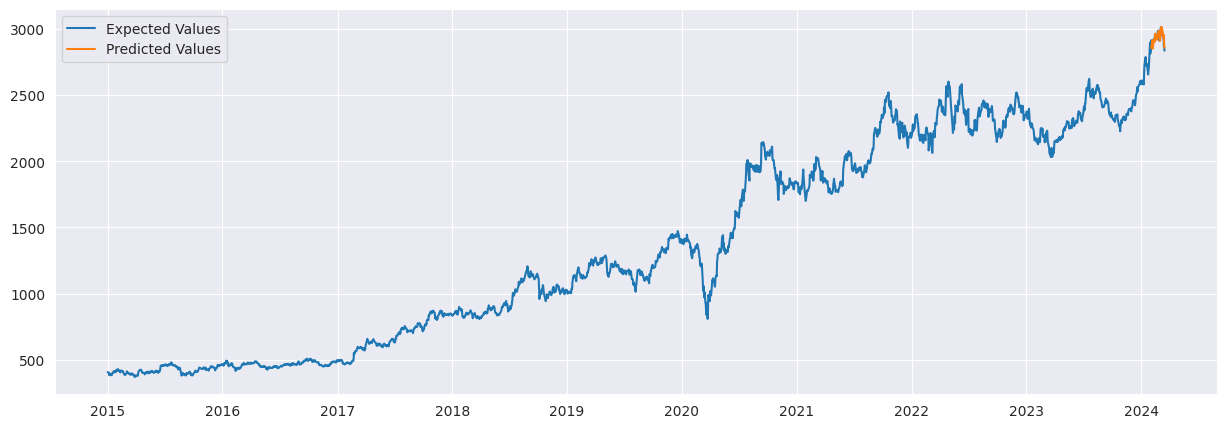

In [41]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['Close'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 33.0781


### Auto ARIMA

In [43]:
!pip install pmdarima

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39910.609, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=1.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=21218.388, Time=1.42 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=21220.568, Time=0.84 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=21218.684, Time=1.58 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=1.55 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=2.78 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=21221.481, Time=3.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=21219.447, Time=1.86 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 15.175 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2273
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -10606.

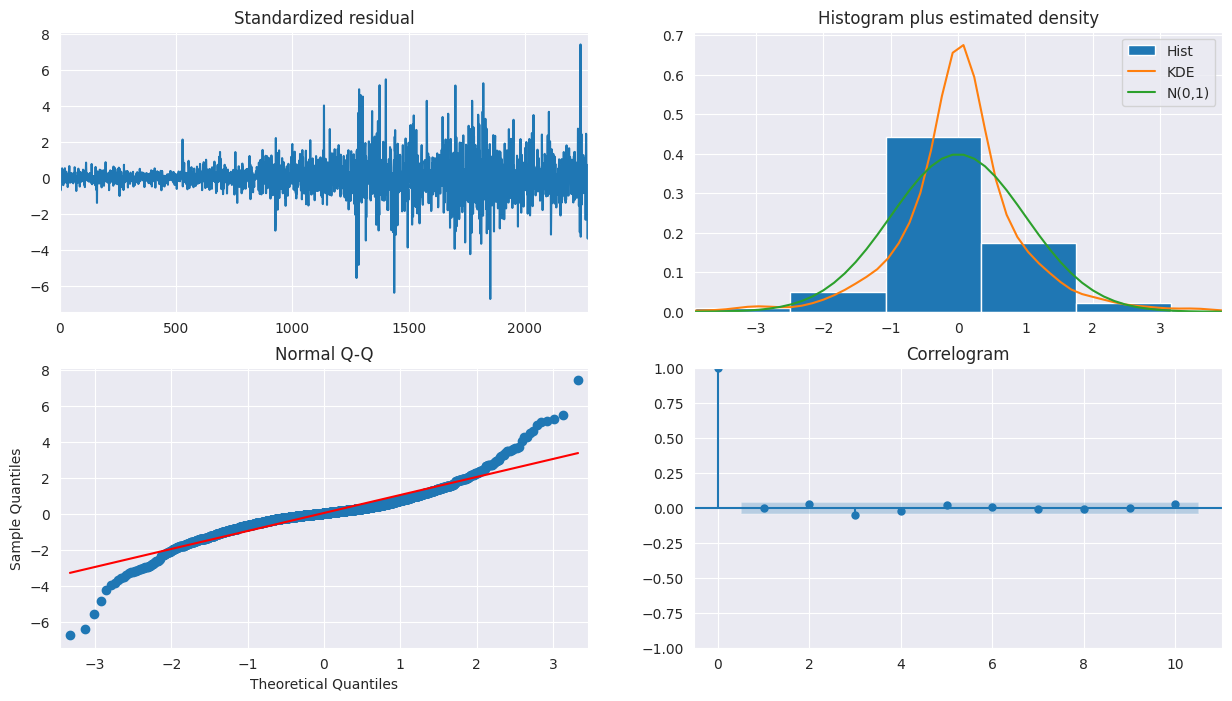

In [44]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
model_autoARIMA = pm.auto_arima(df['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [45]:
#Modeling
# Build Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Close'], order=(1,0,1))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2273
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -10605.700
Date:                Fri, 15 Mar 2024   AIC                          21219.400
Time:                        19:08:22   BIC                          21242.316
Sample:                             0   HQIC                         21227.760
                               - 2273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1371.0803   5498.833      0.249      0.803   -9406.435    1.21e+04
ar.L1          0.9999      0.001   1194.436      0.000       0.998       1.002
ma.L1          0.0174      0.015      1.186      0.2

In [46]:
# Forecast
fc = fitted.forecast(321, alpha=0.05)  # 95% conf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



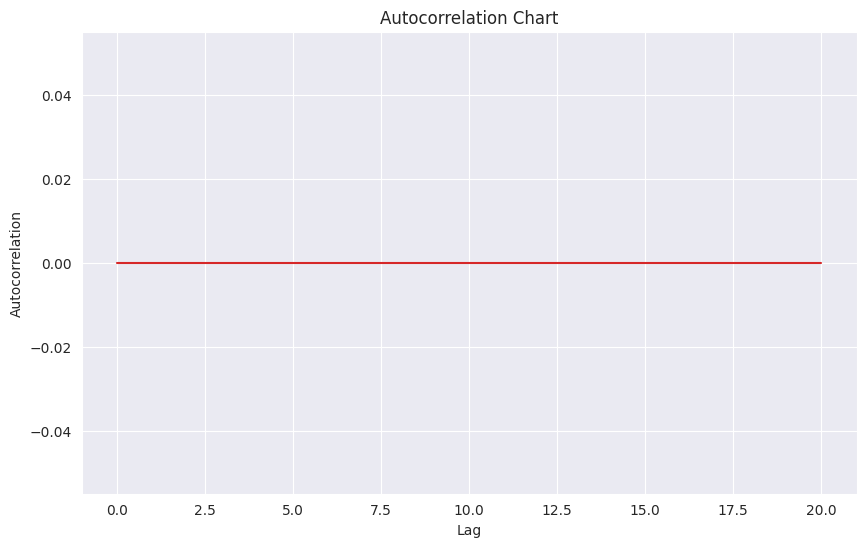

In [47]:
df['diff_Close'] = df['Close'] - df['Close'].shift(1)
# Compute the autocorrelation
autocorrelation = sm.tsa.acf(df['diff_Close'], nlags=20)

# Plot the autocorrelation chart
plt.figure(figsize=(10, 6))
plt.stem(range(len(autocorrelation)), autocorrelation, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Chart')
plt.show()

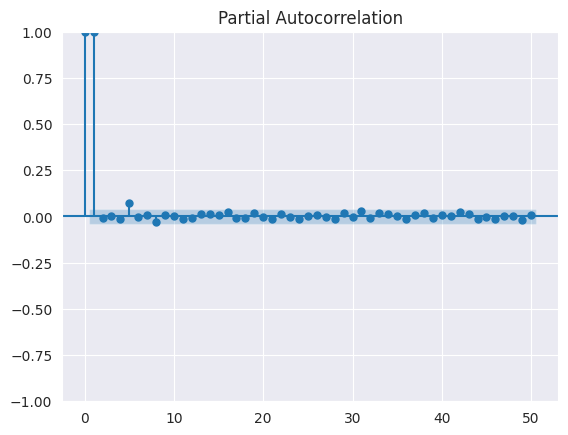

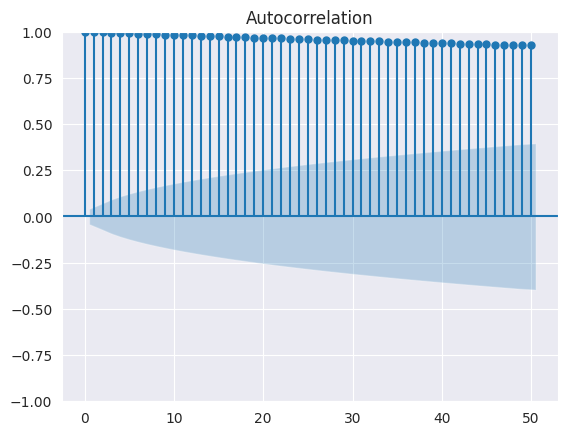

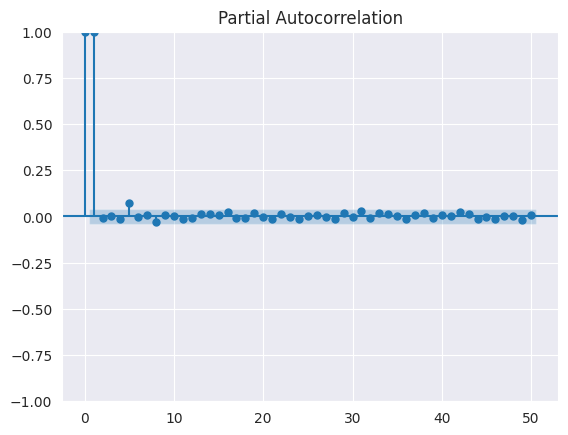

In [48]:
import statsmodels.api as sm

p = 1
d = 1
q = 1

train_np = train.values.astype('float64')
model = sm.tsa.ARIMA(train_np, order=(p, d, q))


# Define the order of differencing, AR, and MA terms
model_fit = model.fit()

# Plot ACF and PACF
plot_acf(train_np, lags=50)
plot_pacf(train_np, lags=50)

In [49]:
p = 1
d = 1
q = 1

# extract the target variable as a numpy array
train_np = train.values.astype('float64')

# fit the ARIMA model
model = sm.tsa.ARIMA(train_np, order=(p, d, q))

# train the ARIMA model
results = model.fit()

# print the summary of the trained model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2243
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10447.363
Date:                Fri, 15 Mar 2024   AIC                          20900.727
Time:                        19:08:26   BIC                          20917.872
Sample:                             0   HQIC                         20906.986
                               - 2243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9336      0.104     -8.958      0.000      -1.138      -0.729
ma.L1          0.9261      0.109      8.467      0.000       0.712       1.141
sigma2       653.2206      9.160     71.312      0.0

In [50]:
# Make predictions
start_idx = len(train)
end_idx = len(train) + len(test) - 1
predictions = results.predict(start=start_idx, end=end_idx)
# Print the predictions
print(predictions)

[2855.80394996 2853.46623274 2855.64879568 2853.61108943 2855.51355312
 2853.73735594 2855.39566692 2853.84741803 2855.29290965 2853.94335531
 2855.20333973 2854.02698047 2855.12526477 2854.09987359 2855.05720956
 2854.16341198 2854.99788822 2854.21879616 2854.94617989 2854.26707262
 2854.90110754 2854.30915351 2854.86181955 2854.34583396 2854.82757359
 2854.37780701 2854.79772258 2854.40567681 2854.77170251 2854.42996993]
